In [9]:
import logging
import os
import json
import jsonpickle
import pickle
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFECV
import utils.models
from utils.abstract import AbstractDetector
from utils.models import load_model, load_models_dirpath, load_ground_truth, wrap_network_prediction
import torch
import torchvision
import skimage.io
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# perform standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
r13_data = '/data/xinqiao/round13/data/'

In [3]:
model_path_list = sorted([os.path.join(r13_data, model) for model in os.listdir(r13_data)])
# load_models_dirpath(model_path_list)

In [4]:
model_frcnn = load_model(os.path.join(model_path_list[26], 'model.pt'))

In [5]:
cls_logits = model_frcnn[0].rpn.head.cls_logits.weight
bbox_pred = model_frcnn[0].rpn.head.bbox_pred.weight
cls_score_fastrcnn = model_frcnn[0].roi_heads.box_predictor.cls_score.weight
bbox_pred_fastrcnn = model_frcnn[0].roi_heads.box_predictor.bbox_pred.weight
print(cls_logits.shape, bbox_pred.shape, cls_score_fastrcnn.shape, bbox_pred_fastrcnn.shape)

torch.Size([3, 256, 1, 1]) torch.Size([12, 256, 1, 1]) torch.Size([33, 1024]) torch.Size([132, 1024])


In [6]:
X = []
y = []
for model_dir in model_path_list:
    model, model_repr, model_class = load_model(os.path.join(model_dir, 'model.pt'))
    model_ground_truth = load_ground_truth(model_dir)
    if model_class != 'FasterRCNN':
        continue
    cls_logits = model.rpn.head.cls_logits.weight.detach().cpu().numpy()[:, :, 0, 0]
    bbox_pred = model.rpn.head.bbox_pred.weight.detach().cpu().numpy()[:, :, 0, 0]
    cls_score_fastrcnn = model.roi_heads.box_predictor.cls_score.weight.detach().cpu().numpy()
    bbox_pred_fastrcnn = model.roi_heads.box_predictor.bbox_pred.weight.detach().cpu().numpy()
    # get first singular value of each weight matrix
    s_cls_logits = np.linalg.svd(cls_logits, compute_uv=False)[0]
    s_bbox_pred = np.linalg.svd(bbox_pred, compute_uv=False)[0]
    s_cls_score_fastrcnn = np.linalg.svd(cls_score_fastrcnn, compute_uv=False)[0]
    s_bbox_pred_fastrcnn = np.linalg.svd(bbox_pred_fastrcnn, compute_uv=False)[0]
    print(f'{model_dir}: {model_ground_truth}, {s_cls_logits}, {s_bbox_pred}, {s_cls_score_fastrcnn}, {s_bbox_pred_fastrcnn}')
    # X.append([s_cls_logits, s_bbox_pred, s_cls_score_fastrcnn, s_bbox_pred_fastrcnn])
    X.append([s_cls_logits, s_bbox_pred, s_cls_score_fastrcnn, s_bbox_pred_fastrcnn])
    y.append(model_ground_truth)
X = np.array(X)
y = np.array(y)

/home/shivam/miniconda3/envs/round13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data/xinqiao/round13/data/id-00000003: 0, 1.2563458681106567, 0.16977562010288239, 7.519247055053711, 1.672845721244812
/data/xinqiao/round13/data/id-00000008: 0, 2.977651357650757, 0.12455525994300842, 54.830902099609375, 4.347867488861084
/data/xinqiao/round13/data/id-00000011: 1, 1.8100924491882324, 0.13517457246780396, 12.753501892089844, 1.689028024673462
/data/xinqiao/round13/data/id-00000013: 0, 3.428643226623535, 0.16770358383655548, 149.97862243652344, 8.244685173034668
/data/xinqiao/round13/data/id-00000014: 0, 1.1539580821990967, 0.16932892799377441, 4.445798397064209, 1.2800770998001099
/data/xinqiao/round13/data/id-00000018: 0, 0.6134487390518188, 0.18848715722560883, 1.5707699060440063, 0.7956131100654602
/data/xinqiao/round13/data/id-00000021: 1, 2.995932102203369, 0.2744660973548889, 54.595733642578125, 4.225073337554932
/data/xinqiao/round13/data/id-00000022: 0, 1.2744570970535278, 0.1620660275220871, 4.769072532653809, 1.285650372505188
/data/xinqiao/round13/data/id-

In [10]:
X = scaler.fit_transform(X)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    print("Ground truth: ", y)
    print("Predictions:  ", list(y_pred))
    print("Prediction Probabilities: ", model.predict_proba(X)[:, 1].round(2))
    print("Accuracy: ", accuracy_score(y, y_pred))
    # get roc auc score
    y_pred_proba = model.predict_proba(X)
    print("ROC AUC: ", roc_auc_score(y, y_pred_proba[:, 1]))

In [12]:
# train random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)
get_metrics(rf, X_test, y_test)

Ground truth:  [0 1 0 1 0 1 1 1 0 0]
Predictions:   [0, 1, 0, 1, 0, 0, 1, 0, 0, 0]
Prediction Probabilities:  [0.34 0.94 0.19 0.96 0.39 0.29 1.   0.14 0.   0.08]
Accuracy:  0.8
ROC AUC:  0.8


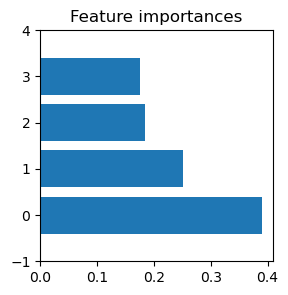

In [13]:
feature_importances = rf.feature_importances_
# plot the feature importances
plt.figure(figsize=(3, 3))
plt.title("Feature importances")
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.ylim([-1, len(feature_importances)])
plt.show()

In [12]:
model_detr = load_model(os.path.join(model_path_list[1], 'model.pt'))[0]
class_labels_classifier = model_detr.class_labels_classifier.weight
box_predictor = model_detr.bbox_predictor.layers[2].weight
print(class_labels_classifier.shape, box_predictor.shape)

torch.Size([34, 256]) torch.Size([4, 256])


In [13]:
model, model_repr, model_class = load_model(os.path.join(model_path_list[1], 'model.pt'))
# list all modules 
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [14]:
X = []
y = []
for model_dir in model_path_list:
    model, model_repr, model_class = load_model(os.path.join(model_dir, 'model.pt'))
    model_ground_truth = load_ground_truth(model_dir)
    if model_class != 'DetrForObjectDetection':
        continue
    class_labels_classifier = model.class_labels_classifier.weight.detach().cpu().numpy()
    class_labels_classifier_bias = model.class_labels_classifier.bias.detach().cpu().numpy()
    bbox_predictor_0 = model.bbox_predictor.layers[0].weight.detach().cpu().numpy()
    bbox_predictor_0_bias = model.bbox_predictor.layers[0].bias.detach().cpu().numpy()
    bbox_predictor_1 = model.bbox_predictor.layers[1].weight.detach().cpu().numpy()
    bbox_predictor_1_bias = model.bbox_predictor.layers[1].bias.detach().cpu().numpy()
    box_predictor_2 = model.bbox_predictor.layers[2].weight.detach().cpu().numpy()
    box_predictor_2_bias = model.bbox_predictor.layers[2].bias.detach().cpu().numpy()

    # get first singular value of each weight matrix
    s_class_labels_classifier = np.linalg.svd(class_labels_classifier, compute_uv=False)[0]
    s_bbox_predictor_0 = np.linalg.svd(bbox_predictor_0, compute_uv=False)[0]
    s_bbox_predictor_1 = np.linalg.svd(bbox_predictor_1, compute_uv=False)[0]
    s_box_predictor_2 = np.linalg.svd(box_predictor_2, compute_uv=False)[0]

    # get l2 norm of bias
    l2_class_labels_classifier_bias = np.linalg.norm(class_labels_classifier_bias)
    l2_bbox_predictor_0_bias = np.linalg.norm(bbox_predictor_0_bias)
    l2_bbox_predictor_1_bias = np.linalg.norm(bbox_predictor_1_bias)
    l2_box_predictor_2_bias = np.linalg.norm(box_predictor_2_bias)
    print(f'{model_dir}: {model_ground_truth}, {s_class_labels_classifier}, {s_bbox_predictor_0}, {s_bbox_predictor_1}, {s_box_predictor_2}, {l2_class_labels_classifier_bias}, {l2_bbox_predictor_0_bias}, {l2_bbox_predictor_1_bias}, {l2_box_predictor_2_bias}')
    X.append([s_class_labels_classifier, s_bbox_predictor_0, s_bbox_predictor_1, s_box_predictor_2, l2_class_labels_classifier_bias, l2_bbox_predictor_0_bias, l2_bbox_predictor_1_bias, l2_box_predictor_2_bias])
    y.append(model_ground_truth)
X = np.array(X)
y = np.array(y)

/data/xinqiao/round13/data/id-00000001: 0, 2.3542823791503906, 5.650344371795654, 13.161962509155273, 5.253539562225342, 0.13359946012496948, 3.251237392425537, 3.019148111343384, 0.15047545731067657
/data/xinqiao/round13/data/id-00000002: 1, 3.5582447052001953, 5.63322639465332, 13.226513862609863, 5.28112268447876, 0.2434142380952835, 3.2649381160736084, 3.0310120582580566, 0.15380489826202393
/data/xinqiao/round13/data/id-00000005: 0, 1.7580280303955078, 5.615273952484131, 13.239805221557617, 5.283750534057617, 0.0949629545211792, 3.2408204078674316, 3.019320011138916, 0.152452290058136
/data/xinqiao/round13/data/id-00000009: 0, 2.2199668884277344, 5.642322540283203, 13.230095863342285, 5.2816057205200195, 0.17026229202747345, 3.259432315826416, 3.0294790267944336, 0.1521792858839035
/data/xinqiao/round13/data/id-00000010: 0, 3.2440550327301025, 5.677167892456055, 13.228046417236328, 5.2794413566589355, 0.17560452222824097, 3.2639434337615967, 3.037623643875122, 0.15246963500976562


In [16]:
X = scaler.fit_transform(X)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
def get_metrics(model, X, y):
    y_pred = model.predict(X)
    print("Ground truth: ", y)
    print("Predictions:  ", list(y_pred))
    print("Prediction Probabilities: ", model.predict_proba(X)[:, 1].round(2))
    print("Accuracy: ", accuracy_score(y, y_pred))
    # get roc auc score
    y_pred_proba = model.predict_proba(X)
    print("ROC AUC: ", roc_auc_score(y, y_pred_proba[:, 1]))

In [39]:
clf = svm.SVC(kernel='linear', C=1, random_state=41)
selector = RFECV(clf, step=1, cv=5, min_features_to_select=10)
selector = selector.fit(X_train, y_train)

newfeats = X_train[:,selector.support_]
model = svm.SVC(kernel='linear', C=1, random_state=41, probability=True)
model.fit(newfeats, y_train)

calibrator = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrator.fit(newfeats, y_train)
print(calibrator.score(newfeats, y_train))

0.72


In [40]:
calibrator.fit(X_train, y_train)
get_metrics(calibrator, X_test, y_test)

Ground truth:  [1 0 1 0 0 0 1]
Predictions:   [1, 0, 1, 1, 1, 0, 1]
Prediction Probabilities:  [0.62 0.3  0.69 0.66 0.71 0.37 0.72]
Accuracy:  0.7142857142857143
ROC AUC:  0.75


In [26]:
# train random forest
# import gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier

# gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(rf, cv='prefit', method='isotonic')
calibrator.fit(X_train, y_train)
get_metrics(calibrator, X_test, y_test)

Ground truth:  [1 0 1 0 0 0 1]
Predictions:   [1, 1, 1, 1, 1, 1, 0]
Prediction Probabilities:  [1.   1.   0.68 1.   0.9  1.   0.2 ]
Accuracy:  0.2857142857142857
ROC AUC:  0.20833333333333331


In [48]:
model, model_repr, model_class = load_model(os.path.join(model_path_list[0], 'model.pt'))
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [42]:
model, model_repr, model_class = load_model(os.path.join(model_path_list[0], 'model.pt'))
w = model.head.classification_head.module_list[5].weight
# get first singular value of each weight matrix
s = np.linalg.svd(w.detach().cpu().numpy(), compute_uv=False)[0]

In [49]:
w = model.head.regression_head.module_list[5].weight
w.shape

torch.Size([16, 256, 3, 3])

In [79]:
X = []
y = []
for model_dir in model_path_list:
    model, model_repr, model_class = load_model(os.path.join(model_dir, 'model.pt'))
    model_ground_truth = load_ground_truth(model_dir)
    if model_class != 'SSD':
        continue

    classifcation_heads = [x.weight.detach().cpu().numpy() for x in model.head.classification_head.module_list]
    regression_heads = [x.weight.detach().cpu().numpy() for x in model.head.regression_head.module_list]
    # convert each matrix to a 2d matrix
    classification_heads = [x.reshape(x.shape[0], -1) for x in classifcation_heads]
    regression_heads = [x.reshape(x.shape[0], -1) for x in regression_heads]

    # get first singular value of each weight matrix
    s_classification_heads = [np.linalg.svd(x, compute_uv=False)[0] for x in classification_heads]
    s_regression_heads = [np.linalg.svd(x, compute_uv=False)[0] for x in regression_heads]

    X.append(s_classification_heads + s_regression_heads)
    y.append(model_ground_truth)
    print(X, y)
    
X = np.array(X)
y = np.array(y)

[[9.356235, 5.6099496, 6.0735145, 4.3650784, 4.5565085, 1.9276024, 1.3857439, 1.4911098, 1.3805761, 1.371061, 1.3890938, 1.4494772]] [0]
[[9.356235, 5.6099496, 6.0735145, 4.3650784, 4.5565085, 1.9276024, 1.3857439, 1.4911098, 1.3805761, 1.371061, 1.3890938, 1.4494772], [27.45671, 19.019611, 18.714893, 15.3470125, 24.302147, 13.223234, 1.3861291, 1.4666705, 1.3886557, 1.3834456, 1.4225346, 1.4948939]] [0, 0]
[[9.356235, 5.6099496, 6.0735145, 4.3650784, 4.5565085, 1.9276024, 1.3857439, 1.4911098, 1.3805761, 1.371061, 1.3890938, 1.4494772], [27.45671, 19.019611, 18.714893, 15.3470125, 24.302147, 13.223234, 1.3861291, 1.4666705, 1.3886557, 1.3834456, 1.4225346, 1.4948939], [74.71136, 103.87771, 95.31542, 66.794464, 93.03276, 35.55504, 1.195148, 2.2805955, 1.7770764, 1.4161965, 1.6418235, 1.442451]] [0, 0, 0]
[[9.356235, 5.6099496, 6.0735145, 4.3650784, 4.5565085, 1.9276024, 1.3857439, 1.4911098, 1.3805761, 1.371061, 1.3890938, 1.4494772], [27.45671, 19.019611, 18.714893, 15.3470125, 24.302

In [81]:
X = scaler.fit_transform(X)
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
clf = svm.SVC(kernel='linear', C=1, random_state=41)
selector = RFECV(clf, step=1, cv=5, min_features_to_select=10)
selector = selector.fit(X_train, y_train)

print(selector.support_)
newfeats = X_train[:,selector.support_]
model = svm.SVC(kernel='linear', C=1, random_state=41, probability=True)
model.fit(newfeats, y_train)

calibrator = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
calibrator.fit(newfeats, y_train)
print(calibrator.score(newfeats, y_train))

[ True  True  True  True  True  True  True False  True  True  True False]
0.6578947368421053


In [90]:
calibrator.fit(X_train[:,selector.support_], y_train)
get_metrics(calibrator, X_test[:,selector.support_], y_test)

Ground truth:  [1 1 1 0 1 1 1 0 1 1]
Predictions:   [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Prediction Probabilities:  [0.39 0.59 0.34 0.73 0.33 0.31 0.35 0.34 0.39 0.38]
Accuracy:  0.2
ROC AUC:  0.3125


In [94]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train[:, selector.support_], y_train)
calibrator = CalibratedClassifierCV(rf, cv='prefit', method='sigmoid')
calibrator.fit(X_train[:, selector.support_], y_train)
get_metrics(calibrator, X_test[:, selector.support_], y_test)

Ground truth:  [1 1 1 0 1 1 1 0 1 1]
Predictions:   [0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
Prediction Probabilities:  [0.08 0.88 0.2  1.   0.11 0.98 0.35 0.02 0.13 0.22]
Accuracy:  0.3
ROC AUC:  0.5


In [ ]:
def load_model_mp(path_list, training, q):
    X = defaultdict(list)
    Y = defaultdict(list)
    for model_path in path_list:
        print(model_path)
        model, model_repr, model_class = load_model(os.path.join(model_path, "model.pt"))
        model_ground_truth = load_ground_truth(model_path)

        feats = get_features(model)
        X[model_class].append(feats)
        if training:
            Y[model_class].append(model_ground_truth)

    q.put((X, Y)) if training else q.put(X)

In [ ]:
model_path_list = sorted([os.path.join(r13_data, model) for model in os.listdir(r13_data)])
q = Queue()
NUM_PROCESSES = 16
for i in range(NUM_PROCESSES):
    if i == NUM_PROCESSES-1:
        p = Process(target=load_model_mp, args=(
            model_path_list[len(model_path_list)//NUM_PROCESSES*i:len(model_path_list)], 
            True, q,
            )
        )
    else:
        p = Process(target=load_model_mp, args=(
            model_path_list[len(model_path_list)//NUM_PROCESSES*i:len(model_path_list)//NUM_PROCESSES*(i+1)], 
            True, q,
            )
        )
    p.start()

X = defaultdict(list)
Y = defaultdict(list)
for i in range(NUM_PROCESSES):
    x, y = q.get()
    print("Process {} finished".format(i))
    for k, v in x.items():
        X[k].append(v)
    for k, v in y.items():
        Y[k].append(v)